# Importing Libraries

In [1]:
from diff_weighted_fields import Grid1D, GaussianFieldGenerator1D, Zeldovich1D, PowerSpectrum
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax
from tqdm import tqdm

#grid setup
L = 4000
N = 1024
dk     = 10  #units of kf 
kmin   = 4   #units of kf
R_smooth = 1.5 #units of cell size
kmax   = 1   #units of kNyq

#define the field and gaussian generator
grid_bare = Grid1D((N,), L, dk = dk, kmax = kmax , kmin =kmin)
grid_clip = Grid1D((N,), L, R_clip = R_smooth, dk =dk, kmax = kmax , kmin =kmin)
grid_gauss = Grid1D((N,), L, R_gauss = R_smooth, dk =dk, kmax = kmax , kmin =kmin)

Using clipping smoothing with R_clip = 1.5 cells (physical = 5.859375); k_smooth = 5.362e-01
Using smoothing smoothing with R_gauss = 1.5 cells (physical = 5.859375); k_smooth = 5.362e-01


In [5]:
print('Grid clip Properties:')
print(grid_clip)

print('Grid grid_gauss Properties:')
print(grid_gauss)

Grid clip Properties:
Using Clipping smoothing with R_clip = 1.5
kmin: 0.006283185307179587
kmax: 0.8042477193189871
dk: 0.015707963267948967
N: 1024
Shape: (1024,)
L: 4000
Volume: 4000.0

Grid grid_gauss Properties:
Using Gaussian smoothing with R_gauss = 1.5
kmin: 0.006283185307179587
kmax: 0.8042477193189871
dk: 0.015707963267948967
N: 1024
Shape: (1024,)
L: 4000
Volume: 4000.0



Text(0, 0.5, 'smoothing kernel')

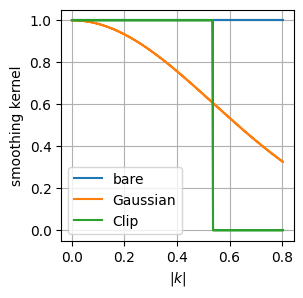

In [6]:
plt.figure(figsize = (3,3),dpi = 100)
plt.plot(grid_bare.kgrid_abs,grid_bare.GRID_SMOOTHING_KERNEL, label = 'bare')
plt.plot(grid_gauss.kgrid_abs,grid_gauss.GRID_SMOOTHING_KERNEL, label = 'Gaussian')
plt.plot(grid_clip.kgrid_abs,grid_clip.GRID_SMOOTHING_KERNEL, label = 'Clip')
plt.grid()
plt.legend()
plt.xlabel(r'$|k|$')
plt.ylabel('smoothing kernel')

This defines the power spectrum we will use:

In [7]:
def PK(k,theta, threshold = 0.001):
    A,R,n = theta
    _p = A*(k*R)**n*jnp.exp(-(k*R)**2)
    sig = jnp.max(_p)
    return _p + sig* threshold

In [20]:
#white noise used to generate the field
keys = split(PRNGKey(2),100)
noise_gauss = jnp.array([grid_gauss.generate_hermitian_noise(x) for x in keys])
noise_clip = jnp.array([grid_clip.generate_hermitian_noise(x) for x in keys])

# Defining main functions 

In [21]:
#gaussian and zeldovich field generators
gen_bare = GaussianFieldGenerator1D(grid_bare, PK)
gen_gauss = GaussianFieldGenerator1D(grid_gauss, PK)
gen_clip = GaussianFieldGenerator1D(grid_clip, PK)

Now, we compare the gaussian realizations using the two different smoothing options:

In [22]:
A = 2.0
n = 2.0
R = grid_gauss.H[0]

theta = jnp.array([A, R, n])

Text(0, 0.5, '$\\delta$')

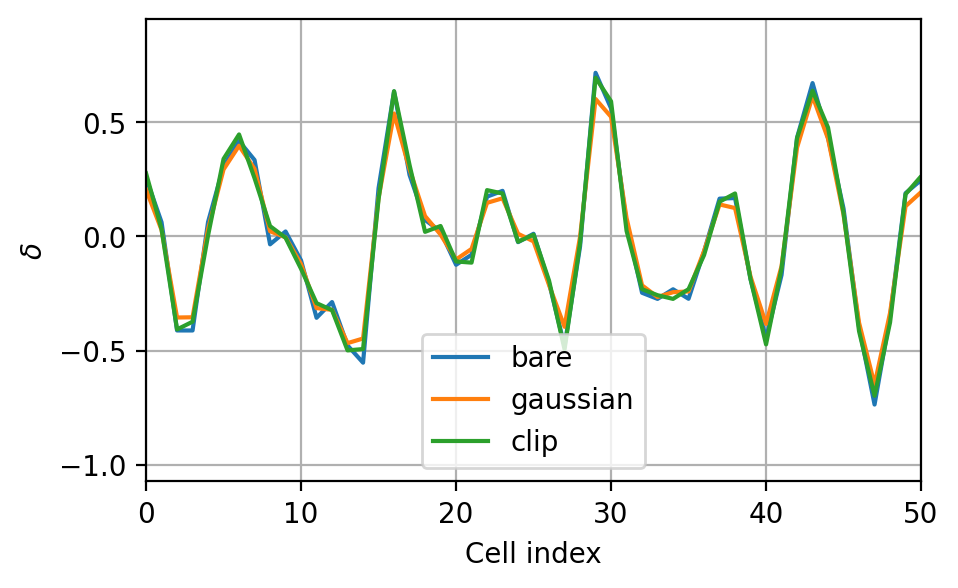

In [26]:
g_bare = gen_bare.make_realization_from_noise(theta,noise_gauss[0])
g_bare.compute_ifft()

g_gauss = gen_gauss.make_realization_from_noise(theta,noise_gauss[0])
g_gauss.compute_ifft()

g_clip = gen_clip.make_realization_from_noise(theta,noise_gauss[0])
g_clip.compute_ifft()
plt.figure(figsize = (5,3), dpi = 200)
plt.plot(g_bare.delta, label = 'bare')
plt.plot(g_gauss.delta, label = 'gaussian')
plt.plot(g_clip.delta, label = 'clip')
plt.grid()
plt.legend()
plt.xlim((0,50))
plt.xlabel('Cell index')
plt.ylabel(r'$\delta$') 

In [27]:
def pk_single_realization(g,theta,noise):
    f = g.make_realization_from_noise(theta,noise)
    f.compute_ifft()
    return PowerSpectrum(f,f)

pk_batch = jax.vmap(pk_single_realization, in_axes=(None, None, 0))

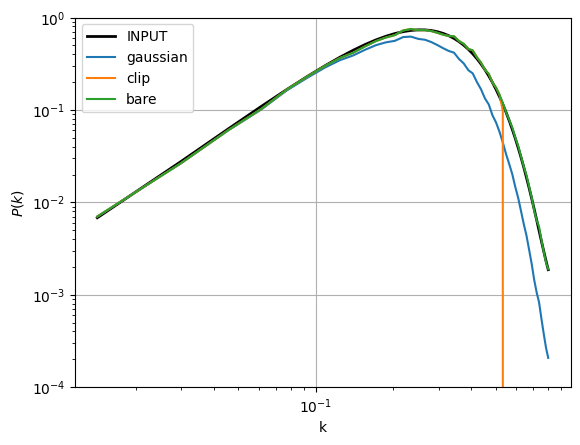

In [28]:
pk_gauss = pk_batch(gen_gauss, theta, noise_gauss)  
pk_clip = pk_batch(gen_clip, theta, noise_gauss)  
pk_bare = pk_batch(gen_bare, theta, noise_gauss)  

plt.figure()
plt.loglog(grid_gauss.k_ctrs, PK(grid_gauss.k_ctrs,theta), label='INPUT', color = 'black', lw = 2)
plt.loglog(grid_gauss.k_ctrs, pk_gauss.mean(axis=0), label='gaussian')
plt.loglog(grid_clip.k_ctrs, pk_clip.mean(axis=0), label='clip')
plt.loglog(grid_bare.k_ctrs, pk_bare.mean(axis=0), label='bare')
plt.xlabel('k')
plt.legend()
plt.ylim((1e-4,1))
plt.ylabel(r'$P(k)$')
plt.grid()